In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
from os.path import join
import warnings
import matplotlib.pyplot as plt

from src import DEFAULT_DIR
from src.XPLAIN_explainer import XPLAIN_explainer
from src.XPLAIN_explanation import XPLAIN_explanation

def get_explanation(dataset_name: str, classifier_name: str, instance_id: int) -> XPLAIN_explanation:
    explainer = XPLAIN_explainer(dataset_name, classifier_name, random_explain_dataset=True)
    instance = explainer.explain_dataset.get_decoded(instance_id)
    cc = explainer.explain_dataset.class_column_name()
    target_class = instance[cc]
    return explainer.explain_instance(instance, target_class=target_class)

def get_data():  
    es = [get_explanation(join(DEFAULT_DIR, "datasets/monks.arff"), clf, i) for i in range(6) for clf in ['nb','sklearn_nb']]
    return es

In [50]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    es = get_data()

compute_lace_step k=21
compute_lace_step k=42
explain_instance errors: [0.16048117811984752, 0.1921993641341072]
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
explain_instance errors: [0.048516900873828706, 0.048516900873828706, 0.03844158315403945, 0.0017123656960313927]
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
explain_instance errors: [0.20308279344486463, 0.17525704149750898, 0.17525704149750898, 0.17525704149750898, 0.17525704149750898, 0.17525704149750898, 0.17348671787638764, 0.003971703036130481]
compute_lace_step k=21
explain_instance errors: [0.008259653056763905]
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_st

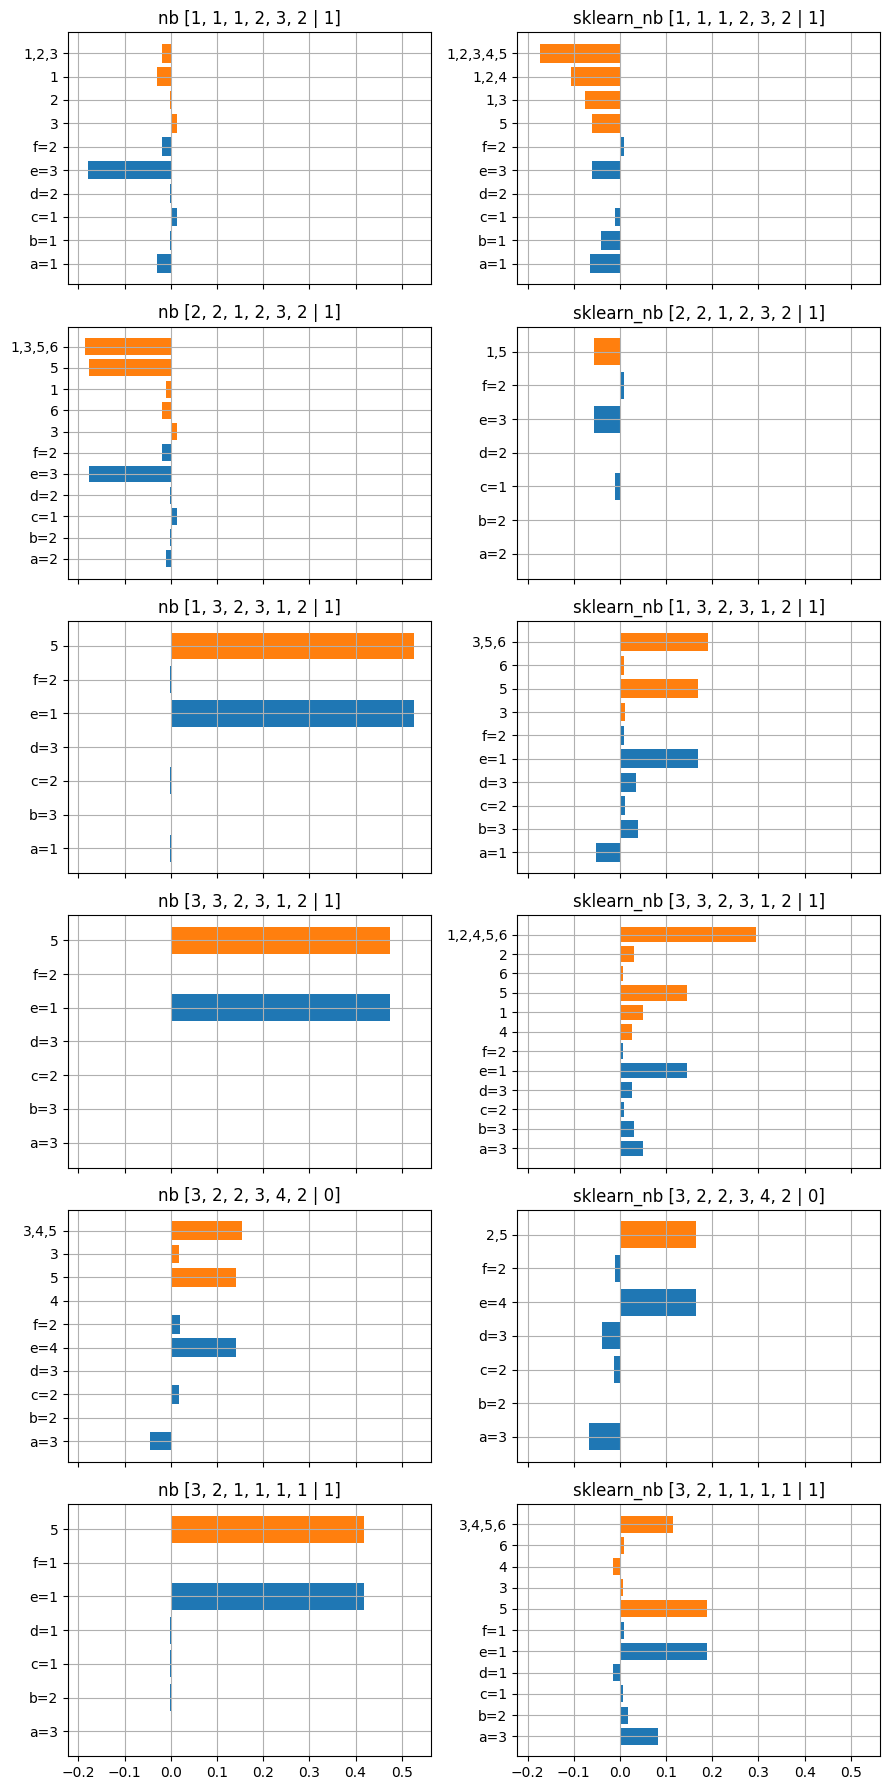

In [53]:
def plot(es):
    plt.rcParams['figure.figsize'] = [9, 18]
    plt.rcParams['figure.dpi'] = 100
    
    fig, axes = plt.subplots(6,2, sharex=True, sharey=False)
    
    for ax,e in zip(list(axes.ravel()), es):
        names = [f"{v.variable.name}={v}" for v in list(e.instance.values())[:-1]] + list(e.map_difference.keys())
        differences = e.diff_single + list(e.map_difference.values())
        ax.barh(names,differences,color=['C0'] * len(list(e.instance.values())[:-1]) + ['C1'] * len(e.map_difference.keys()))
        ax.grid(True)

    for ax,t in zip(
        list(axes.ravel()),
        es):
        xp = t.XPLAIN_explainer_o
        ax.set_title(f"{xp.classifier_name} {t.instance}")
    
    fig.tight_layout()
    
plot(es)